### Implementation of Convolutional Variational Autoencoder at MNIST dataset 

In [20]:
import torch 
import torch.nn as nn 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors

In [2]:
from helper_data import get_dataloaders_mnist
from helper_train import train_vae_v1
from helper_utils import set_deterministic, set_all_seeds
from helper_plotting import plot_training_loss
from helper_plotting import plot_generated_images
from helper_plotting import plot_latent_space_with_labels
from helper_plotting import plot_images_sampled_from_vae

In [3]:
# import for training purposes 
from helper_evaluate import compute_accuracy
from helper_evaluate import compute_epoch_loss_classifier
from helper_evaluate import compute_epoch_loss_autoencoder
import time 
import torch.nn.functional as F 

In [4]:
DEVICE= torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
RANDOM_SEED= 123 
LEARNING_RATE= 0.0005 
BATCH_SIZE=32 
NUM_EPOCHS= 20 

set_deterministic
set_all_seeds(RANDOM_SEED)  #set random seed so we can reproduce the same weights at each run 

cuda


Get the dataset from MNIST 

In [5]:
train_loader, valid_loader, test_loader= get_dataloaders_mnist(
    batch_size= BATCH_SIZE, num_workers= 2, validation_fraction=0)

print("Training set:\n")
for images, labels in train_loader:
    print(f"Image batch dimension: {images.size()}")
    print(f"Image label dimension: {labels.size()}")
    print(labels[:10])
    break 

print("\nValidation set:")
for images, labels in valid_loader:
    print(f"Image batch dimension: {images.size()}")
    print(f"Image label dimension: {labels.size()}")
    print(labels[:10])
    break 

print("\nTest set:")
for images, labels in test_loader:
    print(f"Image batch dimension: {images.size()}")
    print(f"Image label dimension: {labels.size()}")
    print(labels[:10])
    break 

Training set:

Image batch dimension: torch.Size([32, 1, 28, 28])
Image label dimension: torch.Size([32])
tensor([1, 2, 1, 9, 0, 6, 9, 8, 0, 1])

Validation set:

Test set:
Image batch dimension: torch.Size([32, 1, 28, 28])
Image label dimension: torch.Size([32])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])


#### Model 
- First we have encoder to encode the input to our latent space of certain dimension 
- We have to create two vectors mean and log variance (this is the sampling part from the forward pass). We use log variance to make learning more stable   
- Then decode the latent space back to the input dimension 
- Calculate reconstruction cost to optimize reconstruction through backpropogation like a regular autoencoder. We also calculate the KL divergence term to make our latent space distribution into a normal distribution  
  
Transpose convolution size calculation formula: $$output = (input-1) * stride -2 *padding +(kernel\_size-1)+1$$

#### KL Divergence term
The difference between VAE and AE is the variance and mean vectors is that we can use to train and make the latent space distribution into a normal distribution, which is better than that of regular AE.  
- To help the model learn a normal distribute latent space, we need to use sampling during a forward pass  
- We retrieve mean and variance from a forward pass  
- Then compute the z as the final output after encoding 
- $z= \mu + \epsilon \cdot \sigma$
- We need a $\mu$ (mean) vector and a variance (vector) to compute this formula. This is why we sample these two after encoding before computing this equation  
- With log variance $\log(\sigma^2)$ as variance, our standard deviation $\sigma=$ $e^{\frac{\log(\sigma^2)}{2}}$


#### Challenges of AE 
Autoencoders don't have a normal distribution, so it becomes difficult to sample in a balanced way. It's also not centered at (0,0) and not a continuous distribution at higher dimensional latent spaces. These shortcomings make it good at reconstructing, but not at generating new outcome/out of distribution data.  

#### What questions VAE tackles 
The only difference between a VAE and AE (in this implementation) is that VAE has an extract step of training mean and variance vectors after encoding. This step is done inside the latent space, and with the KL divergence term error, the mean and variance vectors tries to reduce to 0 and 1 respectively while training. This is a normal distribution.  


#### Loss Function 
- VAE is loss is $\alpha \cdot L_1 + L_2,$ where L1 is the reconstruction and L2 is KL divergence loss. 
- The $\alpha$ is a weight, the higher it is, the more focused our model is focused on reconstruction loss. 

**Note**: The KL divergence term: $$-{\frac{1}{2}} \cdot \sum(1+{\log(\sigma^2)}-{\mu^2}-\sigma^2)$$  
reduces to 0 when variance ($\sigma^2$) =1 and mean ($\mu$) =0. Which is why it makes latent space a normal distribution.  

**Implementation of KL**:  
- The summation sums across features (in columns)  
- We take the mean loss over all the batches (divide by number of batches)
  
The normal distribution is now a continuous distribution and we can sample balancely, so VAE is better at generating new outputs.   
  
*log_var means variance but taken in a log* 

In [6]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__() 
        self.shape= args    # reshape the input later at latent space
    def forward(self, x):
        return x.view(self.shape)
    
class Trim(nn.Module):  # used to cut out dimensions to remain the same as input image 
    def __init__(self,*args):
        super().__init__() 
    def forward(self,x):
        return x[:,:,:28,:28]
class VAE(nn.Module):   # input 32 x 1 x 28 x 28    32 training samples, 1 channel each, 28 x 28
    def __init__(self):
        super().__init__() 

        # encode the input 
        self.encoder=nn.Sequential(
            nn.Conv2d(1,32,stride=(1,1), kernel_size=(3,3), padding=1), # 32 x 28 x 28 
            nn.LeakyReLU(0.01),
            nn.Conv2d(32, 64, stride=(2,2), kernel_size=(3,3), padding=1),  # 64 x 14 x 14
            nn.LeakyReLU(0.01),
            nn.Conv2d(64,64, stride=(2,2), kernel_size=(3,3), padding=1 ),   # 64 x 7 x 7
            nn.LeakyReLU(0.01),
            nn.Conv2d(64,64, stride= (1,1), kernel_size=(3,3),padding=1),    # 64 x 7 x 7
            nn.Flatten()    # flatten into a row vector 1x 3136 
        )
        # get two vectors for mean and variance 
        self.z_mean= nn.Linear(3136,2)    # linear transformation into latent sapce 
        self.z_log_var= nn.Linear(3136,2)
       
        self.decoder= nn.Sequential(
            nn.Linear(2,3136), # linear transformation back into the original dimension
            Reshape(-1,64,7,7),  # remake the hidden space output into 64 x 7 x 7 with the rest training examples (same dimension as our last conv layer output)
            nn.ConvTranspose2d(64,64,stride=(1,1),kernel_size=(3,3), padding= 1), #keep same channels and expand the input through transpose convolution. Same dimension
            nn.LeakyReLU(0.01),   #non-linear transformation after every transpose convolution
            nn.ConvTranspose2d(64,64,stride=(2,2), kernel_size=(3,3),padding=1),  #same channel, and expand the input even more. 1 x 64 x 13 x 13
            nn.LeakyReLU(0.01),   #continue scaling 
            nn.ConvTranspose2d(64,32,stride=(2,2), kernel_size=(3,3), padding=0), # scale down to 32 channels, 1 x 32 x 27 x 27
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(32,1,stride= (1,1), kernel_size=(3,3), padding=0), #revert back to 1 x 1 x 29 x 29
            Trim(),     #1x 29 x 29 -> 1 x 28 x 28 take the first 28 pixels of the output. Back to the same dimension and channel of the original input
            nn.Sigmoid()    # use sigmoid because training data is transformed to [0,1]
        )

    def encoding_fn(self, x):   # only encoding (same as returning the z in the forward() function) 
        x= self.encoder(x) 
        z_mean, z_log_var= self.z_mean(x), self.z_log_var(x)   # extract mean and variance vector 
        encoded= self.reparameterize (z_mean, z_log_var)
        return encoded 
    
    def reparameterize(self, z_mu, z_log_var):  # sampling the epsilon after encoding 
        # pass in mean and log_variance (variance)
        eps= torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device()) 
        # keep the batch_size to sample all batches 

        # compute z from formula
        z = z_mu + eps * torch.exp(z_log_var/2.0)    #standard deviation is e^(log_var/2)
        return z 

    def forward(self,x):
        x= self.encoder(x)
        z_mean, z_log_var= self.z_mean(x), self.z_log_var(x)   # retrieve 2 vectors before latent space (both created from linear transformation with different weights) to train for normal distribution
        encoded= self.reparameterize(z_mean,z_log_var)  # compute z (the actual latent space)
        decoded= self.decoder(encoded)  
        return encoded, z_mean, z_log_var, decoded  # we need these 4 vectors for back prop

### Training  
- Training requires us to compute both the reconstruction and KL loss term  
- Optimize the parameters by reducing the total loss, which in turn reduces both reconstruction and the KL divergence term  
- KL Divergence is summed over the dimensions (columns) then take the mean  
- Reconstruction cost is also calculated based on the loss across all pixels then taken the average

In [7]:
model = VAE() 
model.to(DEVICE)    # use your device to process the model 
optimizer= torch.optim.Adam(model.parameters(), lr= LEARNING_RATE)

In [8]:
def train_vae(num_epochs, model, optimizer, device, train_loader, loss_fn= None, logging_interval= 100, skip_epoch_stats=False, reconstruction_term_weight=1, save_model=None):
    # record our losses including reconstruction and KL 
    log_dict= {
        "train_combined_loss_per_batch":[], 
        "train_combined_loss_per_epoch": [],
        "train_reconstruction_loss_per_batch":[],
        "train_KL_loss_per_batch":[] 
    }
    if loss_fn is None: 
        loss_fn= F.mse_loss # we use MSE error by default because the training data is transformed into [0,1]. Use Binary Cross Entropy for {0,1} outputs
    start_time = time.time() 
    for epoch in range(num_epochs): 
        model.train()   # initialize training (gradient descent activates)
        for batch_idx, (features,_) in enumerate (train_loader):    # go through every batch in the train loader
            features= features.to(device)   # intput data, send tensor to device (GPU for processing if has)

            # foward propogation 
            encoded, z_mean, z_log_var, decoded= model(features)

            #KL divergence loss (see the formula above, the summation will be summed across columns because those are our features, the rows are different training samples)
            kl_div= -0.5* torch.sum(1+z_log_var-z_mean**2-torch.exp(z_log_var), axis=1) 

            batchsize= kl_div. size(0)  # the first dimension of KL is # of rows, which is # of training samples 
            kl_div= kl_div.mean()   # average the loss across all elements into a scalar 

            # reconstruction loss 
            pixelwise= loss_fn(decoded,features,reduction="none")    # element wise MSE, preserves the original dimension
            
            
            pixelwise= pixelwise.view(batchsize,-1).sum(axis=1) # reformat error and sum across pixels aka columns (all channels if we have)
            # current dim: batchsize x 1 
            # calculate the mean across all elements with total number of elements
            pixelwise = pixelwise.mean()

            # reconstruction_term_weight is the alpha of the Loss (weight, higher the more focused on reconstruction)
            loss= reconstruction_term_weight*pixelwise +kl_div   # accumulate to be total loss (recontsruction_term_weight is a multiplier)
                # we try to minimize this total loss (both reconstruction and KL div loss)
            optimizer.zero_grad() # clear out gradients 
            loss.backward()     # calculate gradients 

            optimizer.step()    # update parameters 

            # logging the weight 
            log_dict["train_combined_loss_per_batch"].append(loss.item())
            log_dict["train_reconstruction_loss_per_batch"].append(pixelwise.item())
            log_dict['train_KL_loss_per_batch'].append(kl_div.item())

            # print training progress
            if not batch_idx % logging_interval:
                print(f"epoch: {(epoch+1):03d}/{num_epochs:%03d} | Batch: {batch_idx:03d}/{len(train_loader)} | Loss: {loss:.5f}")
            
        print(f"Total training time: {((time.time()-start_time)/60):.3f} min")
    
    return log_dict

In [9]:
log_dict = train_vae_v1(num_epochs=NUM_EPOCHS, model=model, 
                        optimizer=optimizer, device=DEVICE, 
                        train_loader=train_loader,
                        skip_epoch_stats=True,
                        logging_interval=50)

Epoch: 001/020 | Batch 0000/1875 | Loss: 130.3181
Epoch: 001/020 | Batch 0050/1875 | Loss: 57.2565
Epoch: 001/020 | Batch 0100/1875 | Loss: 57.4025
Epoch: 001/020 | Batch 0150/1875 | Loss: 52.5144
Epoch: 001/020 | Batch 0200/1875 | Loss: 54.3379
Epoch: 001/020 | Batch 0250/1875 | Loss: 45.6559
Epoch: 001/020 | Batch 0300/1875 | Loss: 48.8631
Epoch: 001/020 | Batch 0350/1875 | Loss: 48.0505
Epoch: 001/020 | Batch 0400/1875 | Loss: 48.6215
Epoch: 001/020 | Batch 0450/1875 | Loss: 46.4247
Epoch: 001/020 | Batch 0500/1875 | Loss: 40.9676
Epoch: 001/020 | Batch 0550/1875 | Loss: 43.2015
Epoch: 001/020 | Batch 0600/1875 | Loss: 45.3407
Epoch: 001/020 | Batch 0650/1875 | Loss: 44.0874
Epoch: 001/020 | Batch 0700/1875 | Loss: 42.2834
Epoch: 001/020 | Batch 0750/1875 | Loss: 45.1215
Epoch: 001/020 | Batch 0800/1875 | Loss: 41.7706
Epoch: 001/020 | Batch 0850/1875 | Loss: 46.7535
Epoch: 001/020 | Batch 0900/1875 | Loss: 46.0852
Epoch: 001/020 | Batch 0950/1875 | Loss: 38.7722
Epoch: 001/020 | Ba

#### Evaluating Peroformance
- The model's performance is not as good because the hidden latent space is only 2 dimensional, so it also suffers from a lot of overlaps 

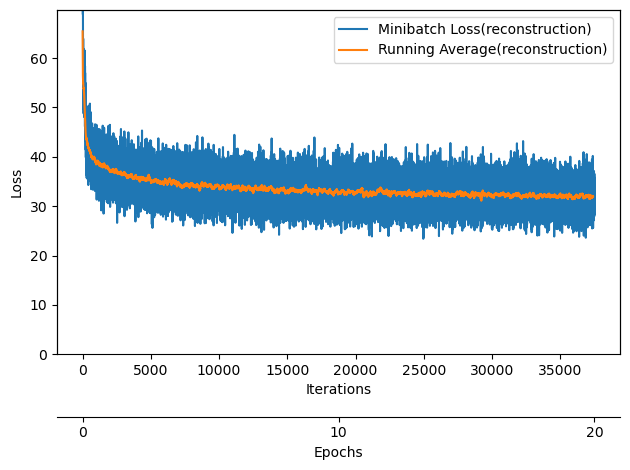

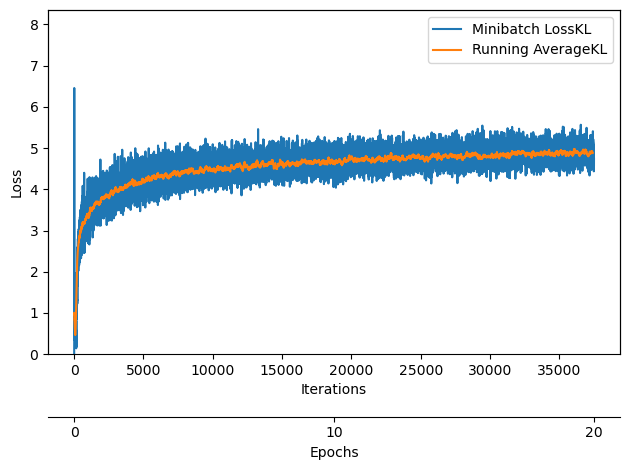

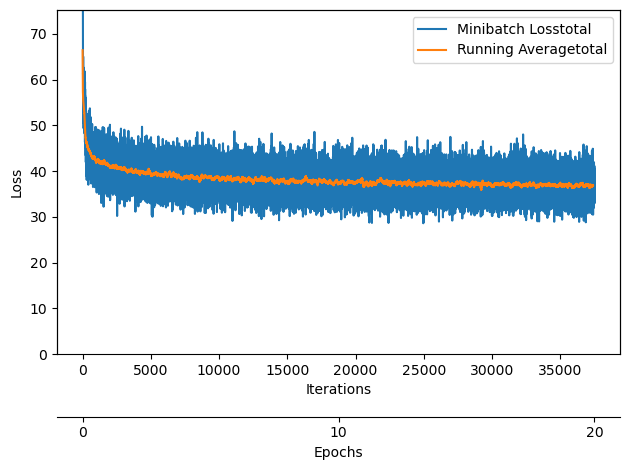

In [10]:
plot_training_loss(log_dict["train_reconstruction_loss_per_batch"], NUM_EPOCHS,custom_label="(reconstruction)")
plot_training_loss(log_dict["train_kl_loss_per_batch"], NUM_EPOCHS, custom_label="KL")
plot_training_loss(log_dict["train_combined_loss_per_batch"], NUM_EPOCHS, custom_label="total")
plt.show() 

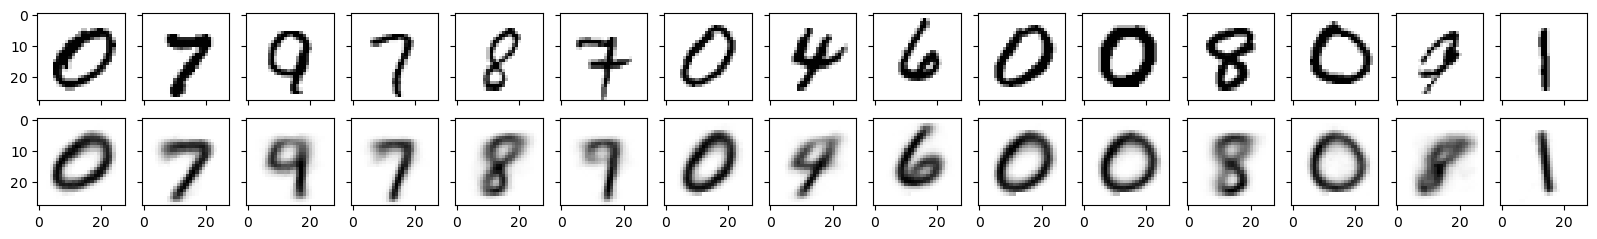

In [11]:
plot_generated_images(data_loader=train_loader, model=model, device=DEVICE,modeltype="VAE")

In [27]:
# plot the latent space distribution 
def plot_latent_space(num_classes, data_loader, encoding_fn, device):
    d={i:[] for i in range(num_classes)}    # create a dictionary of index and a list as value, where we have number_classes
    with torch.no_grad(): 
        for i, (features,targets) in enumerate(data_loader):
            features= features.to(device)
            targets= targets.to(device)

            # get the encoded output (after encoder, and sampling mean and variance)
            embedding= encoding_fn(features)

            for i in range(num_classes):
                if i in targets:
                    mask= targets==i 
                    d[i].append(embedding[mask].to("cpu").numpy())
        
        colors= list(mcolors.TABLEAU_COLORS.items())
        for i in range(num_classes):
            d[i]=np.concatenate(d[i])
            plt.scatter(
                d[i] [:,0], d[i][:,1],
                color= colors[i][1],
                label= f"{i}",
                alpha= 0.1
            )
        plt.legend() 

#### Latent Space
- Because our latent space is low dimension, the spread is still clustered, but the distribution is getting closer to center at (0,0) because of our training to reduce KL divergence term 
- Distribution is shaping like normal distribution
- Shaping like multi-variate Gaussian distribution (need a histogram for visualization)

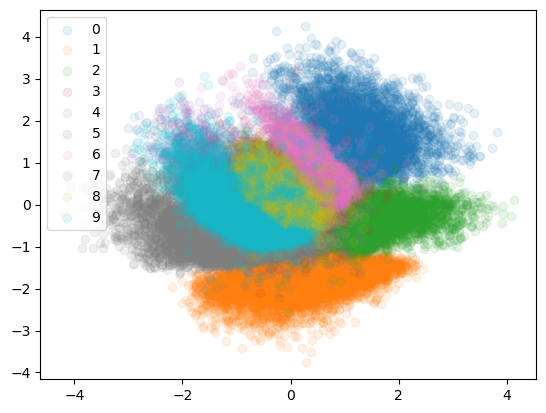

In [28]:
plot_latent_space(num_classes=10, data_loader=train_loader, encoding_fn=model.encoding_fn, device=DEVICE)

plt.legend() 
plt.show()

#### Sampling a point (generating output)
Take a random vector and use the model to generate an output (based on the distribution in the latent space) 

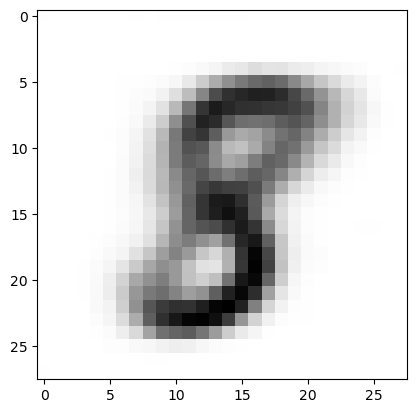

In [29]:
with torch.no_grad(): 
    new_im= model.decoder(torch.tensor([0.0,0.03]).to(DEVICE))
    new_im.squeeze_(0)
    new_im.squeeze_(0)
plt.imshow(new_im.to("cpu").numpy(),cmap="binary")
plt.show()

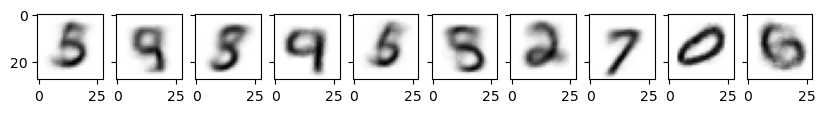

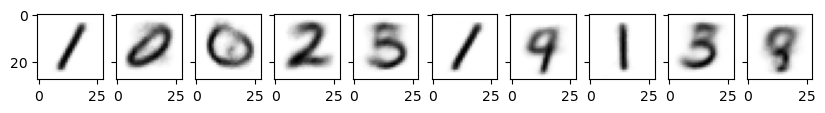

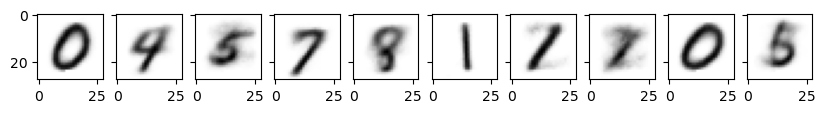

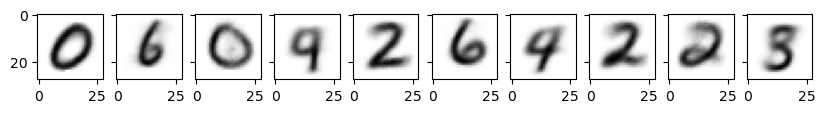

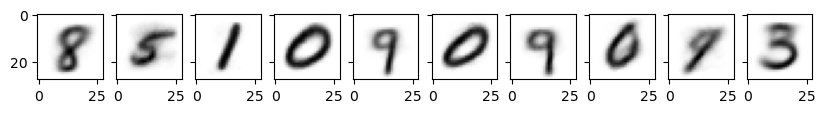

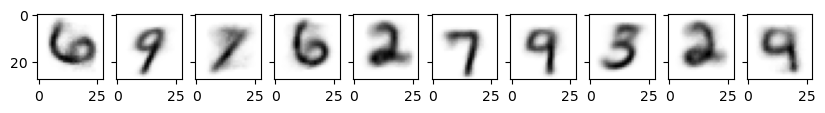

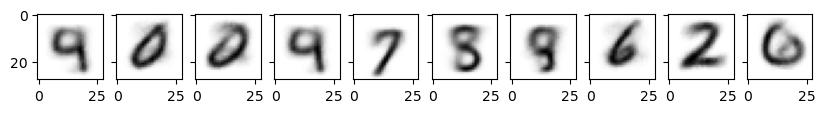

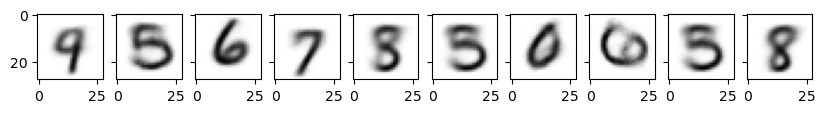

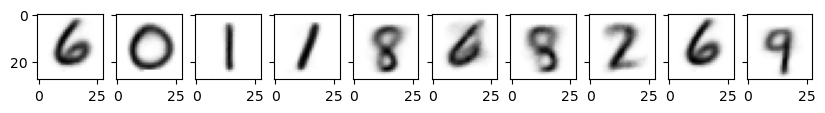

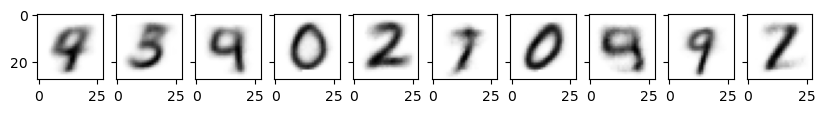

In [30]:
for i in range(10):
    plot_images_sampled_from_vae(model=model, device=DEVICE,latent_size=2)
    plt.show() 